In [139]:
#load packages
%matplotlib inline

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

from skimage.io import imread, imshow

from sklearn.preprocessing import LabelEncoder

import cv2


import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
!pip install ipynb

In [16]:
from ipynb.fs.defs.CNN import check_grey_imgs, transform_image

In [3]:
#path to data

TRAIN_LABELS_PATH = './data/street-view-getting-started-with-julia/TrainLabelsExtended.csv'
TRAIN_IMG_PATH = './data/street-view-getting-started-with-julia/trainResized/'
TEST_IMG_PATH = './data/street-view-getting-started-with-julia/testResized/'

In [4]:
train_df = pd.read_csv(TRAIN_LABELS_PATH)


### Label Encoding

In [5]:
train_df_enc = train_df.copy()

In [7]:
label_enc = LabelEncoder()
train_df_enc['Label'] = label_enc.fit_transform(train_df_enc['Class'])
train_df_enc

,ID,Class,Label
0,5944,H,17
1,11109,Y,34
2,11177,Y,34
3,1380,I,18
4,9773,F,15
...,...,...,...
18737,10112,K,20
18738,4076,S,28
18739,2999,S,28
18740,5404,h,43


In [8]:
replaced_labels = dict(enumerate(label_enc.classes_))
# replaced_labels

### Load transformed data

In [17]:
transformed_data = np.load('transformed_data.npz')
transformed_data.files

['X_train_', 'X_test_', 'y_train_', 'y_test_']

In [19]:
X_train_ = transformed_data[transformed_data.files[0]] 
X_test_ = transformed_data[transformed_data.files[1]]
y_train_ = transformed_data[transformed_data.files[2]].flatten()
y_test_ = transformed_data[transformed_data.files[3]].flatten()

### Resize imgs

In [101]:
def resize_img(original_arr):
    new_arr = np.empty([original_arr.shape[0]] + [32, 32, 3])
    n = 0
    for i in original_arr:
        
        new_i = cv2.resize(i, (32, 32), interpolation = cv2.INTER_LANCZOS4)
        new_arr[n] = new_i
        
        n+=1
        
    return new_arr

In [108]:
X_train_res = resize_img(X_train_)
X_test_res = resize_img(X_test_)

print(X_train_res.shape)
print(X_test_res.shape)


(14993, 32, 32, 3)
(3749, 32, 32, 3)


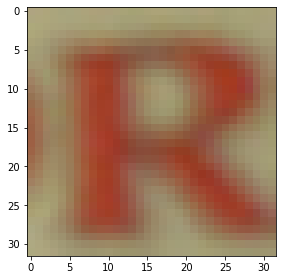

In [109]:
imshow(X_train_res[6]);

### VGG16

In [22]:
num_classes = len(np.unique(y_train_))
num_classes

62

In [134]:

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg_model.trainable = False

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [135]:
# input_ = keras.layers.Input(shape=(20, 20, 3), name='image_input')
# resize = keras.layers.Resizing(32, 32)(input_)
input_ = keras.layers.Input(shape=(32, 32, 3), name='image_input')

x = vgg_model(inputs = input_)

x = keras.layers.Flatten(name='flatten')(x)
x = keras.layers.Dense(128, activation='relu', name='fc1')(x)
# x = keras.layers.Dense(254, activation='relu', name='fc2')(x)
output_ = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model = keras.Model(input_, output_)


In [136]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               65664     
_________________________________________________________________
predictions (Dense)          (None, 62)                7998      
Total params: 14,788,350
Trainable params: 73,662
Non-trainable params: 14,714,688
_________________________________________________________________


In [137]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [133]:
history = model.fit(X_train_res, y_train_, epochs=10, 
                   validation_data=(X_test_res, y_test_))

Train on 14993 samples, validate on 3749 samples
Epoch 1/10
 1632/14993 [==>...........................] - ETA: 1:57 - loss: 4.1151 - accuracy: 0.0338

KeyboardInterrupt: 

### ResNet50

In [138]:
num_classes

62

In [148]:
resnet_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (32, 32, 3))
resnet_model.trainable = False

In [149]:
x = resnet_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.4)(x)
predictions =  keras.layers.Dense(num_classes, activation= 'softmax')(x)
model = keras.Model(inputs = resnet_model.input, outputs = predictions)

In [150]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [151]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [152]:
history = model.fit(X_train_res, y_train_, epochs=3, 
                   validation_data=(X_test_res, y_test_))

Train on 14993 samples, validate on 3749 samples
Epoch 1/3
14993/14993 [==============================] - 312s 21ms/sample - loss: 4.0273 - accuracy: 0.1325 - val_loss: 4.1290 - val_accuracy: 0.0131
Epoch 2/3
14993/14993 [==============================] - 137s 9ms/sample - loss: 3.9151 - accuracy: 0.2498 - val_loss: 4.1276 - val_accuracy: 0.0149
Epoch 3/3
14993/14993 [==============================] - 139s 9ms/sample - loss: 3.8690 - accuracy: 0.2935 - val_loss: 4.1348 - val_accuracy: 0.0157
